In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [22]:
import functions.parsers as pars
from functions.interpolation import interpolative_merge
from functions.cleaners import fill_timegaps
import visualization.plot as vpt

import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

## Load Data

### filepaths

In [38]:
gas_file = r"../../datastreams/GAS_FLOW/Export (2021-11-30 180000 to 2021-12-14 140512).csv" #r"data/FlowData/Export (2021-11-29 132252 to 2021-12-03 142723).csv"
xrd_file = r"../../raw/Y-400/Y-400_scan_combined.txt"
topas_file = r"../../refinements/Y-400/Results_Y-400.txt"
ms_file = r"../../datastreams/MS/Y-400/0512202101.asc"
heater_file = r"../../datastreams/Heater/Y-400/MAX013.xlsm"

### dataframes

In [101]:
df_ms = pars.ms(ms_file)
df_gas = pars.gas_system(gas_file)
df_heater = pars.heater(heater_file)
df_xrd = pars.danmax_xrd(xrd_file, xscan=True)
df_topas = pars.topas(topas_file)

## Merging Topas and XRD

In [102]:
df_xrd_top = pars.join_xrd_topas(df_topas, df_xrd, xscans=True)

## Fixing data gaps

In [119]:
df_total = fill_timegaps(df_xrd_top, threshold=120, freq="3S", xscans=True)

<AxesSubplot:xlabel='XRDTimeStamp'>

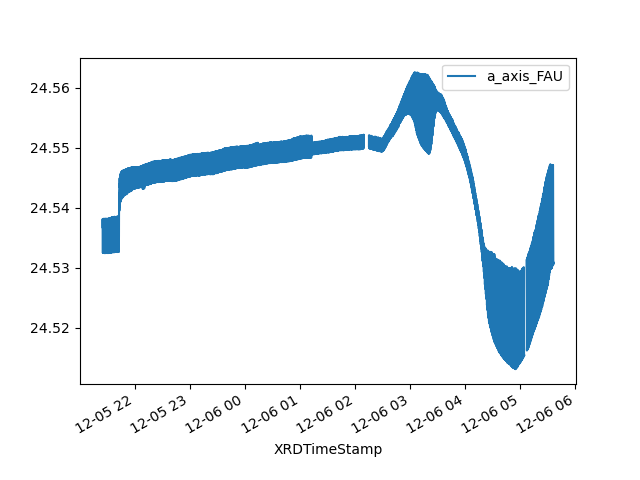

In [120]:
df_total.plot(x='XRDTimeStamp', y="a_axis_FAU")

## Interpolation

In [121]:
interpolative_merge(df1=df_total, df2=df_gas, df1_time="XRDTimeStamp", df2_time="Timestamp", columns=["FI111_PV", "FI111_SP", "FIC111_SP", "FIC111_PV", "GVV111_HS", "GVV121_HS", "GBV122_HS"], inplace=True)
interpolative_merge(df1=df_total, df2=df_heater, df1_time="XRDTimeStamp", df2_time="HistoricalTimeString", columns=["TIC100_PV", "TIC100_SP"], inplace=True)

MS_columns = [col for col in df_ms.columns[1:].to_list() if col not in ["RelTime[s]", "MSTimeStamp"]]
interpolative_merge(df1=df_total, df2=df_ms, df1_time="XRDTimeStamp", df2_time="MSTimeStamp", columns=MS_columns, floor=["Cycle"] , inplace=True)

df_total["Rel.Time/min"] = (df_total["XRDTimeStamp"] - df_total["XRDTimeStamp"][0]).dt.total_seconds()/60
df_total = df_total.set_index("Rel.Time/min").reset_index()

## Visualization

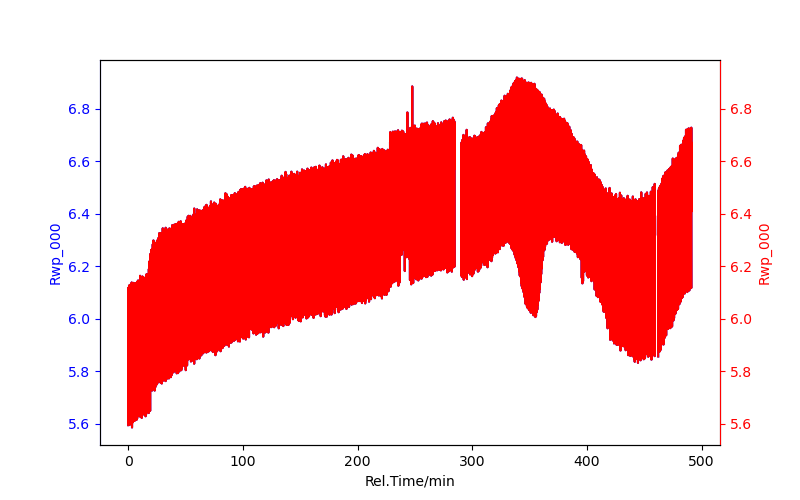

In [122]:
vpt.plot(df_total)

## To Csv

In [123]:
import os
import re

sample = r"Y-400"

result_name = os.path.join(fr"../../FINISHED/{sample}/", f"{sample}_interpolated_dataset.csv")
df_total.to_csv(result_name, index=False)

df_ms.to_csv(os.path.join(fr"../../FINISHED/{sample}/", f"{sample}_MS.csv"), index=False)
df_gas.to_csv(os.path.join(fr"../../FINISHED/{sample}/", f"{sample}_gasflows.csv"), index=False)
df_heater.to_csv(os.path.join(fr"../../FINISHED/{sample}/", f"{sample}_heater.csv"), index=False)
df_xrd_top.to_csv(os.path.join(fr"../../FINISHED/{sample}/", f"{sample}_xrd_topas.csv"), index=False)

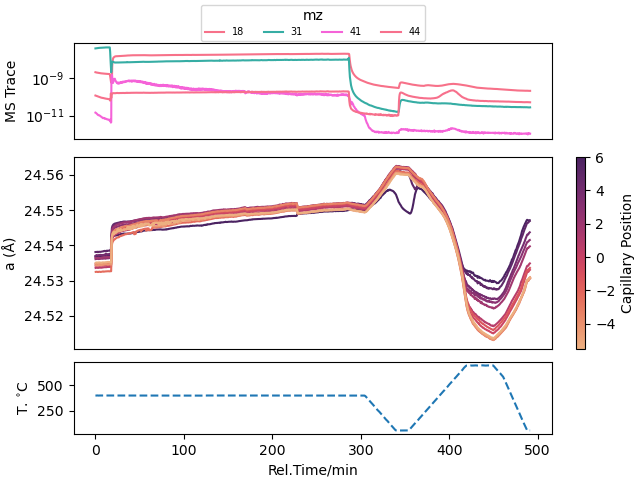

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, gridspec_kw={'height_ratios':[2, 4, 1.5]}, constrained_layout=True)


ms_data = data_2[['Rel.Time/min', 18, 31, 41, 44]]
sns.lineplot(data=pd.melt(ms_data, ['Rel.Time/min']), x='Rel.Time/min', y='value', hue='variable', palette='husl', ax=axs[0])
axs[0].set_yscale("log")
axs[0].set_ylabel('MS Trace')
axs[0].set_xlabel('')
axs[0].axes.xaxis.set_ticks([])
axs[0].legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.45), fontsize=7, title='mz')

norm = plt.Normalize(data_2.x.unique().astype('float').min(), data_2.x.unique().astype('float').max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

sns.lineplot(data=data_2, x='Rel.Time/min', y='a_axis_FAU',hue='x', ax=axs[1], palette="flare_r")

#axs2nd = axs[1].twinx()

#data_2.plot(x='Rel.Time/min', y='GVV111_HS', ax=axs2nd)


axs[1].set_ylabel(r'a (Å)')
axs[1].set_xlabel('')
axs[1].get_legend().remove()
axs[1].axes.xaxis.set_ticks([])
axs[1].figure.colorbar(sm, ax=axs[1], label='Capillary Position')


data_2.plot(x='Rel.Time/min', y='TIC100_PV', ls='--', ax=axs[2], legend=False, ylabel=r'T. $^{\circ}$C')

fig.savefig('../../FINISHED/Y-400.png', dpi=300)